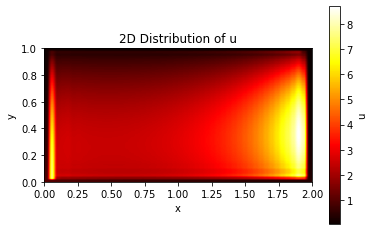

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

# 2阶高斯积分点和权重
gauss_points = np.array([-0.5773502691896257, 0.5773502691896257])
gauss_weights = np.array([1.0, 1.0])

# ABCD顶点坐标
A = np.array([0, 0])
B = np.array([2, 0])
C = np.array([2, 1])
D = np.array([0, 1])

# 定义区域的尺寸
Lx = B[0]
Ly = C[1]

# 定义有限元网格
nx = 50              # x方向上的节点数
ny = 50              # y方向上的节点数
hx = Lx / (nx - 1)  # x方向上的步长
hy = Ly / (ny - 1)  # y方向上的步长

# 网格节点坐标
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
xx, yy = np.meshgrid(x, y)

# 猜测解u=Exp(-x-y) f=Exp(-u)
u = np.exp(-xx - yy)
f = np.exp(-u)

# 最大迭代次数和误差
max_iter = 100
tolerance = 1e-4

# 牛顿迭代法求解
for itr in range(max_iter):
    # 计算有限元刚度矩阵和右端向量
    K = np.zeros((nx * ny, nx * ny))
    F = np.zeros(nx * ny)

    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            index = i + j * nx

            # 高斯积分近似计算刚度矩阵和右端向量
            for gx in gauss_points:
                for gy in gauss_points:
                    x_pos = x[i] + 0.5 * hx * gx
                    y_pos = y[j] + 0.5 * hy * gy

                    # Jacobian
                    det_J = 0.25 * hx * hy

                    # 形函数和导数计算
                    N = np.array([(1 - gx) * (1 - gy), (1 + gx) * (1 - gy), (1 + gx) * (1 + gy), (1 - gx) * (1 + gy)]) / 4.0
                    dN_dx = np.array([-(1 - gy), 1 - gy, 1 + gy, -(1 + gy)]) / (4.0 * hx)
                    dN_dy = np.array([-(1 - gx), -(1 + gx), 1 + gx, 1 - gx]) / (4.0 * hy)

                    # 矩阵元积分计算
                    K_element = np.zeros((4, 4))
                    F_element = np.zeros(4)
                    for m in range(4):
                        for n in range(4):
                            K_element[m, n] = (dN_dx[m] * dN_dx[n] + dN_dy[m] * dN_dy[n]) * det_J
                        F_element[m] = N[m] * f[i, j] * det_J

                    # 重组矩阵
                    for m in range(4):
                        for n in range(4):
                            K[index + m, index + n] += K_element[m, n]
                        F[index + m] += F_element[m]

    # Dirichlet边界条件 
    # 设置边界条件值为0
    for i in range(nx):
        index = i
        K[index, :] = 0
        K[index, index] = 1
        F[index] = 0

        index = i + (ny - 1) * nx
        K[index, :] = 0
        K[index, index] = 1
        F[index] = 0

    for j in range(ny):
        index = j * nx
        K[index, :] = 0
        K[index, index] = 1
        F[index] = 0

        index = nx - 1 + j * nx
        K[index, :] = 0
        K[index, index] = 1
        F[index] = 0

    # 解线性方程组
    du = np.linalg.solve(K, F)

    u_new = u + du.reshape((nx, ny))

    f_new = np.exp(-u_new)

    # 误差计算
    relative_diff = np.sum((u_new - u)**2) / np.sum(u**2)
    
    if relative_diff < tolerance:
        u = u_new
        f = f_new
        break

    # 更新u和f的值
    u = u_new
    f = f_new

plt.imshow(u.T, origin='lower', extent=[0, Lx, 0, Ly], cmap='hot')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D distribution of u')
plt.show()


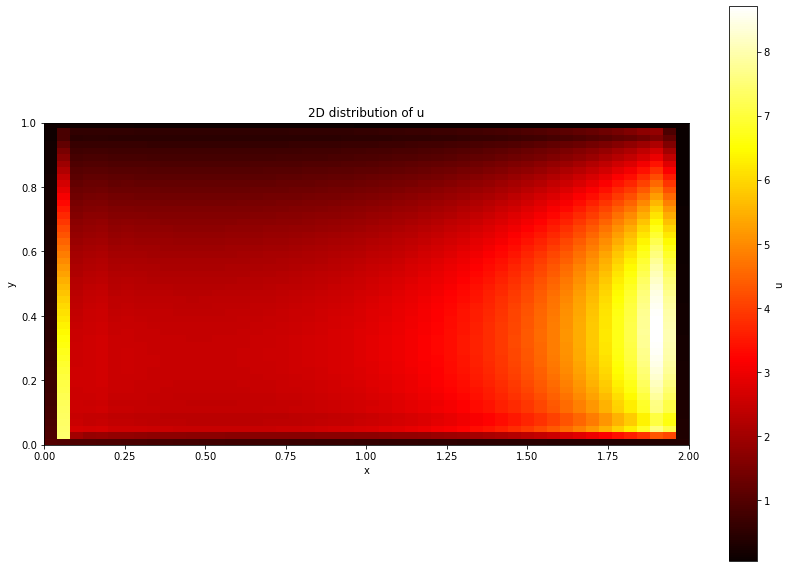

In [50]:
plt.figure(figsize=(12, 8))

plt.imshow(u.T, origin='lower', extent=[0, Lx, 0, Ly], cmap='hot')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D distribution of u')
plt.show()

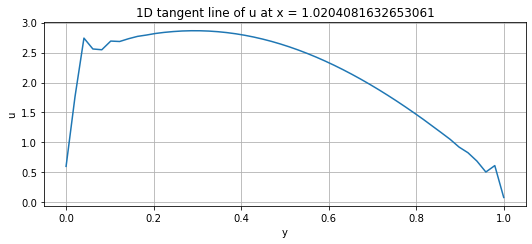

In [51]:
x_idx = 25
plt.plot(y, u[x_idx, :])
plt.xlabel('y')
plt.ylabel('u')
plt.title('1D tangent line of u at x = {}'.format(x[x_idx]))
plt.grid()
plt.show()